# HPAP107 scRNA-seq and CODEX Integration (without cell type annotations)

Overview

This tutorial demonstrates how to integrate HPAP107 scRNA-seq and CODEX datasets from human pancreas using CelLink.

Outline
1. DATA input
2. Data preprocessing
3. Cellink object construction and alignment
4. Feature imputation and cell-type matching
5. Visualization

Notes
- Adjust file paths and parameters to your local environment and dataset sizes.

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import requests
import os
import zipfile

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc

from sklearn.utils.extmath import randomized_svd
from matplotlib.lines import Line2D

from sklearn.metrics.pairwise import cosine_similarity
import sys
import seaborn as sns

from cellink import Cellink

/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data input

Download the example HPAP107 preprocessed AnnData files from the provided Dropbox link. The archive contains preprocessed AnnData objects for combined scRNA, CODEX, and shared-feature subsets. If using your own data, update the file paths accordingly.

In [ ]:
#download HPAP107 data
dropbox_url = "https://www.dropbox.com/scl/fo/pnzya149wk2uq7ak4yvej/ADsoD-Hz0s1BGBrAco-w3lU?rlkey=101pdmutrilndv2j4jxa2n5w9&e=1&st=rxntw6f0&dl=1"
response = requests.get(dropbox_url)
with open("HPAP107_data.zip", "wb") as f:
    f.write(response.content)

print("download success")

extract_dir = "unzipped_HPAP107_data"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile("HPAP107_data.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("unzipped data in:", extract_dir)

In [ ]:
# Load AnnData objects for the preprocessed datasets and datasets with shared features in two modalities
combined_adata = sc.read_h5ad('unzipped_HPAP107_data/pancreas/combined_adata.h5ad')
protein_adata_filter = sc.read_h5ad('unzipped_HPAP107_data/pancreas/protein_adata_filter.h5ad')
rna_shared = sc.read_h5ad('unzipped_HPAP107_data/pancreas/rna_shared.h5ad')
protein_shared = sc.read_h5ad('unzipped_HPAP107_data/pancreas/protein_shared.h5ad')

/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Loaded AnnData objects
- `combined_adata`: the full scRNA AnnData with RNA features and metadata.
- `protein_adata_filter`: the CODEX/protein AnnData object filtered for QC.
- `rna_shared` / `protein_shared`: matched-feature AnnData objects containing only features present in both modalities used for alignment.

Each AnnData is expected to contain `.X` (expression), `.obs` (cell metadata), and optionally `.obsm['spatial']` for CODEX spatial coordinates.

## Data preprocessing


Copy `cell_type` to `cell_type1` and then remove the original `cell_type` to evaluate no celltype task. If your dataset lacks cell-type annotations, skip this block.

In [ ]:
if 'cell_type' in protein_adata_filter.obs.columns:
    # Create a new column 'cell_type1' based on 'cell_type' or any other logic you want for metrics calculation
    combined_adata.obs['cell_type1'] = combined_adata.obs['cell_type'].copy()
    protein_adata_filter.obs['cell_type1'] = protein_adata_filter.obs['cell_type'].copy()
    rna_shared.obs['cell_type1'] = rna_shared.obs['cell_type'].copy()
    protein_shared.obs['cell_type1'] = protein_shared.obs['cell_type'].copy()
    
    # Delete the old 'cell_type' column
    del combined_adata.obs['cell_type']
    del protein_adata_filter.obs['cell_type']
    del rna_shared.obs['cell_type']
    del protein_shared.obs['cell_type']

## Cellink object construction and alignment

Create a `Cellink` instance with full and shared AnnData objects, and optionally split data into batches for efficient processing.

In [4]:
arr = [rna_shared, protein_shared]
cellink = Cellink(full_ann1 = combined_adata, full_ann2 = protein_adata_filter, shared_ann1 = rna_shared, shared_ann2 = protein_shared)
cellink.split_into_batches(arr, 10000, seed = 100)

Cell annotations are not provided. Perform one-time reciprocal UOT!
The first modality is split into 1 batches, and max batch size is 5141.
The second modality is split into 2 batches, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0', '0<->1'].


Alignment key parameters and tuning guidance

- wt1, wt2: Graph smoothing shrinkage weights applied during the graph smoothing step. The smoothing result is computed as: wt * original_features + (1 - wt) * neighborhood_average. These weights control the relative importance of the center cell. Typical values are 0.3，0.5，0.7, 1. Use lower wt (more smoothing) when data are noisy; use wt=1 to disable smoothing.You can try all of them to figure out which one is best.

- n_neighbors (K_Neighbourhood): Number of nearest neighbors used to build the KNN graph. The source code accepts this parameter when constructing graphs. Suggested defaults: 10 (recommended) or 15 for larger datasets. For very small datasets, use 5.

- reg: Entropic regularization coefficient used in unbalanced OT Sinkhorn. Controls the smoothness and effective sparsity of the transport matrix. Larger reg lead to smoother (less sparse) transport; smaller reg lead to sharper (more sparse) transport. Default: 0.01. Be cautious when setting drastically different reg values across modalities, as it may bias rows/columns to dominate.

- lambd: Entropic regularization coefficient used in balanced OT. It controls the overall transport loss and numerical behaviour. Setting lambd too low can harm convergence and lead to a drop in alignment accuracy. Default 0.01; change gradually and monitor convergence.

- sparse: When True, CelLink uses an LBFGS-based solver designed to produce sparser (near one-to-one) correspondences. This often yields crisper matches but is slower and can be numerically less stable on some datasets. When `sparse=False`, Sinkhorn-based dense solvers are used.

- iterative (bool) and numItermax: With `iterative=True`, CelLink runs the iterative unbalanced OT refinement stage (Stage II). When cell-type annotations are available, iterative refinement is recommended because the algorithm can leverage annotations to improve matching consistency across cell types. `numItermax` controls the Sinkhorn/LBFGS maximum iterations — increase it (for example to 1000 or more) if the solver emits convergence warnings.

- reg_m (tuple): KL-divergence mass regularization coefficients used by unbalanced Sinkhorn; tune when necessary to control mass deviation between modalities.


In [ ]:
cellink.alignment(wt1 = 0.5, wt2 = 0.5, n_neighbors=10,
                  reg = 0.01, lambd = 0.01, reg_m1 = (20, 0.01), reg_m2 = (0.01, 20), numItermax = 1000, iterative=True, sparse = False)

Now at batch 0<->0...
Now at batch 0<->1...


## Feature imputation and cell-type matching

After alignment, learned transport maps are used to impute cross-modal features and predict cell types by aggregating transport mass to annotation classes. 

In [ ]:
rna_source_ct_array = np.zeros(shape = rna_shared.shape[0], dtype = 'object')
rna_predict_ct_array = np.zeros(shape = rna_shared.shape[0], dtype = 'object')

protein_source_ct_array = np.zeros(shape = protein_shared.shape[0], dtype = 'object')
protein_predict_ct_array = np.zeros(shape = protein_shared.shape[0], dtype = 'object')

rna_aligned_protein = np.zeros(shape = (combined_adata.shape[0], protein_adata_filter.shape[1]))
protein_aligned_rna = np.zeros(shape = (protein_adata_filter.shape[0], combined_adata.shape[1]))

# For each batch, assign predicted cell types based on transport weights
for i in range(len(cellink.partition1)):
    cell_id = cellink.partition1[i]
    protein_id = cellink.partition2[[j for (k, j) in cellink.partition_d1_to_d2 if k == i][0]]
    for j in range(len(cell_id)):
        ori_ct = combined_adata[cell_id, :].obs['cell_type1'].iloc[j]
        target_cell_types = protein_adata_filter[protein_id, :].obs['cell_type1']
        weight_distribution = {}
        for target_cell_type in np.unique(target_cell_types):
            # Find indices of cells in the target dataset belonging to this cell type
            target_indices = np.where(target_cell_types == target_cell_type)[0]
            # Sum the weights in the transport map for these indices
            # This gives the total transport weight directed towards cells of this target cell type
            total_weight = cellink.cell_correspondence_partition1[i][j, target_indices].sum()
            # Store the total weight in the dictionary
            weight_distribution[target_cell_type] = total_weight
        sct = ori_ct # change into self
        pct = max(weight_distribution, key = weight_distribution.get)
        rna_source_ct_array[cell_id[j]] = sct 
        rna_predict_ct_array[cell_id[j]] = pct
        rna_aligned_protein[cell_id[j]] = cellink.feature_imputation_partition1[i][j]

# Repeat for protein batches
for i in range(len(cellink.partition2)):
    cell_id = cellink.partition2[i]
    rna_id = cellink.partition1[[k for (k, j) in  cellink.partition_d1_to_d2 if j == i][0]]
    for j in range(len(cell_id)):
        ori_ct = protein_adata_filter[cell_id, :].obs['cell_type1'].iloc[j]
        target_cell_types = combined_adata[rna_id, :].obs['cell_type1']
        weight_distribution = {}
        for target_cell_type in np.unique(target_cell_types):
            # Find indices of cells in the target dataset belonging to this cell type
            target_indices = np.where(target_cell_types == target_cell_type)[0]
            # Sum the weights in the transport map for these indices
            # This gives the total transport weight directed towards cells of this target cell type
            total_weight = cellink.cell_correspondence_partition2[i][j, target_indices].sum()
            # Store the total weight in the dictionary
            weight_distribution[target_cell_type] = total_weight
        sct = ori_ct # change into self
        pct = max(weight_distribution, key = weight_distribution.get)
        protein_source_ct_array[cell_id[j]] = sct 
        protein_predict_ct_array[cell_id[j]] = pct
        protein_aligned_rna[cell_id[j]] = cellink.feature_imputation_partition2[i][j]

## Visualization

Compute UMAPs and produce embedding panels and confusion matrices to evaluate alignment.

In [ ]:
# Perform UMAP embedding on concatenated features for visualization
import umap
matched_rna = rna_source_ct_array == rna_predict_ct_array
matched_protein = protein_source_ct_array == protein_predict_ct_array

scrna_all = np.concatenate([combined_adata.X, rna_aligned_protein], axis = 1)
codex_all = np.concatenate([protein_aligned_rna, protein_adata_filter.X], axis = 1)
dataall_2 = np.concatenate([scrna_all, codex_all], axis = 0)
embedding_2 = umap.UMAP(n_components=2, n_epochs = 500, n_neighbors = 15, random_state = 30, min_dist = 0.5).fit_transform(dataall_2)
ct_array_double_2 = np.concatenate([rna_source_ct_array, protein_source_ct_array], axis = 0)

Perform PCA to reduce dimensionality before computing UMAP. This often speeds UMAP and removes noise while preserving major structure. We use 30 PCs in this example.

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30, random_state=0)
data_pca = pca.fit_transform(dataall_2)

# Then apply UMAP on PCA-reduced data
embedding_2 = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.5,
    n_epochs=500,
    random_state=30
).fit_transform(data_pca)
ct_array_double_2 = np.concatenate([rna_source_ct_array, protein_source_ct_array], axis = 0)

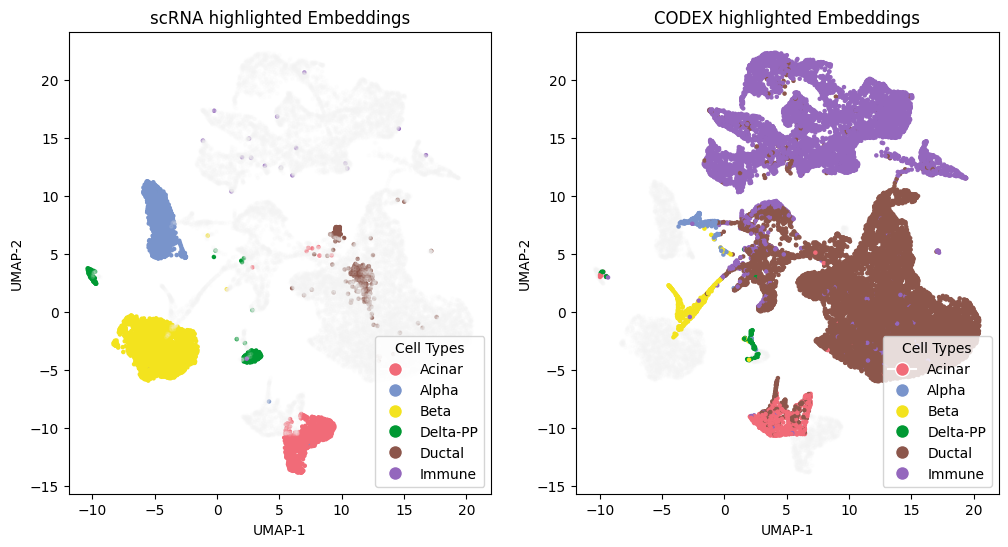

In [14]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
datatype = ['scRNA', 'CODEX']
ct_array_double = ct_array_double_2
#datatype_array_double = np.concatenate([np.repeat(datatype[0], sum(matched_rna)), np.repeat(datatype[1], sum(matched_protein))], axis = 0)
ct_array1 = combined_adata.obs['cell_type1'].values
ct_array2 = protein_adata_filter.obs['cell_type1'].values 

color_palette = plt.cm.tab10(np.linspace(0, 1, 10))[::-1]
cts = np.unique(ct_array_double)
num_type = len(cts)
if num_type > 10:
    repeats = -(-num_type // 10)
    color_palettes = np.tile(color_palette, (repeats, 1))
    colors = color_palettes[:num_type]
else:
    colors = color_palette[:num_type]
colorbar = {t: colors[i] for i, t in enumerate(cts)}

manual_colors = ['#F26B78', '#7995CC', '#F4E41E']
for i, color in enumerate(manual_colors):
    if i < len(cts):
        colorbar[cts[i]] = np.array([int(color.strip('#')[j:j+2], 16) / 256 for j in (0, 2, 4)] + [1])  # Convert hex to RGB tuple

if len(cts) >= 4:
    colorbar[cts[3]] = (0, 0.6, 0.2, 1.0)
    
color_points = np.array([colorbar[i] for i in ct_array_double])

# dts = np.unique(datatype_array_double)
# color_datatype = ["#FFA500", "#004D99"]
# colorbardt = {t: color_datatype[i] for i, t in enumerate(dts)}
# color_dt = np.array([colorbardt[i] for i in datatype_array_double])

grey = np.array([0.95, 0.95, 0.95, 0.1])[np.newaxis, :]

protein_id = np.array(range(0, len(ct_array1)))
rna_id = np.array(range(len(ct_array1), len(ct_array_double)))
color_points1 = color_points.copy()
color_points1[rna_id, :] = grey
color_points2 = color_points.copy()
color_points2[protein_id, :] = grey

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points1, s=5.)
axs[1].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points2, s=5.)
axs[0].set_title('scRNA highlighted Embeddings')
axs[1].set_title('CODEX highlighted Embeddings')
axs[0].set_xlabel('UMAP-1')
axs[0].set_ylabel('UMAP-2')
axs[1].set_xlabel('UMAP-1')
axs[1].set_ylabel('UMAP-2')
for i in axs:
    i.set_facecolor('none')
fig.patch.set_facecolor('none')

legend_celltype = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                              markerfacecolor=c, markersize=10) for t, c in colorbar.items()]
# legend_dt = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
#                             markerfacecolor=c, markersize=10) for t, c in colorbardt.items()]

axs[0].legend(handles = legend_celltype, title = "Cell Types", loc = "lower right")
#plt.gca().add_artist(legend1)
axs[1].legend(handles = legend_celltype, title = "Cell Types", loc = "lower right")


#plt.savefig('/home/luosanj/alignment/CelLink/benchmark/CelLink_figures/pancreas_uot.pdf', transparent=True, format = 'pdf')
plt.show()
